IMPORTS

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from time import perf_counter

LOADING DATA

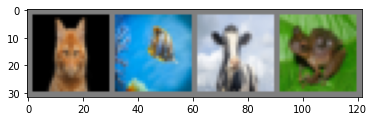

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset_path = r".\trainData"
test_dataset_path = r".\testData"
saved_model_path = './mdl.pth'

batch_size = 4

train_transforms = transforms.Compose([
    transforms.Resize((28,28)), # Resizing all images to same size (28x28)
    transforms.ToTensor(),  # Converting img to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalazing data
])

# train data
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path,transform = train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=1)

# test data
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path,transform = train_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=1)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#showing random train batch
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

MODEL

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, 
                            kernel_size = 5, stride = 1, padding = 2)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                            kernel_size = 5, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                            kernel_size = 5, stride = 1, padding = 0)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        self.tanh = nn.Tanh()
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = self.tanh(x)
        
        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x

In [12]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
  (tanh): Tanh()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


TRAINING

[1,     4] loss: 2.315
[1,     8] loss: 2.328
[1,    12] loss: 2.320
[1,    16] loss: 2.337
[1,    20] loss: 2.303
[1,    24] loss: 2.305
[1,    28] loss: 2.306
[1,    32] loss: 2.283
[1,    36] loss: 2.301
[1,    40] loss: 2.301
[1,    44] loss: 2.297
[1,    48] loss: 2.297
[1,    52] loss: 2.277
[1,    56] loss: 2.315
[1,    60] loss: 2.326
[1,    64] loss: 2.333
[1,    68] loss: 2.297
[1,    72] loss: 2.293
[2,     4] loss: 2.281
[2,     8] loss: 2.299
[2,    12] loss: 2.297
[2,    16] loss: 2.335
[2,    20] loss: 2.293
[2,    24] loss: 2.316
[2,    28] loss: 2.327
[2,    32] loss: 2.298
[2,    36] loss: 2.300
[2,    40] loss: 2.284
[2,    44] loss: 2.347
[2,    48] loss: 2.267
[2,    52] loss: 2.326
[2,    56] loss: 2.300
[2,    60] loss: 2.301
[2,    64] loss: 2.290
[2,    68] loss: 2.334
[2,    72] loss: 2.314
[3,     4] loss: 2.296
[3,     8] loss: 2.295
[3,    12] loss: 2.270
[3,    16] loss: 2.312
[3,    20] loss: 2.307
[3,    24] loss: 2.286
[3,    28] loss: 2.304
[3,    32] 

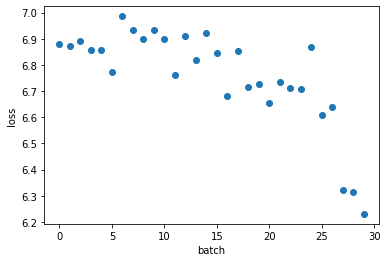

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

x= []
y = []

timerStart = perf_counter()

for epoch in range(30):  # epochs

    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4 == 3:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 4:.3f}')
            x.append((i+epoch*len(train_loader))/4)
            y.append(running_loss / 4)
            running_loss = 0.0

timerStop = perf_counter()
print(f'Finished Training in {timerStop-timerStart:0.2f}s') 

plt.scatter(x,y)
plt.xlabel("batch")
plt.ylabel("loss")
plt.show()

SAVING/LOADING MODEL

In [14]:

# torch.save(model.state_dict(), saved_model_path)
# model.load_state_dict(torch.load(saved_model_path))


TESTING MODEL

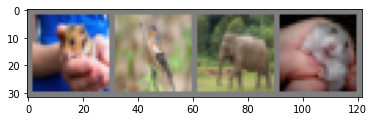

frog
frog
frog
frog


In [15]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# print(test_dataset.class_to_idx.keys())
classes = ['bird', 'camel', 'car', 'cat', 'cow', 'dog', 'elephant', 'fish', 'frog', 'hamster']
outputs = model(images)
# print(outputs)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images.cpu()))
for i in range(len(predicted)):
    print(classes[predicted[i]])

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

Accuracy of the network: 20 %
